# Why some molecules have a color: Conjugated bond chains

TODO Write intro paragraph

## Introduction

I did my PhD in optical spectroscopy.

https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Electronic_Spectroscopy/Electronic_Spectroscopy_Basics/What_Causes_Molecules_to_Absorb_UV_and_Visible_Light

> If you extend this to compounds with really massive delocalisation, the wavelength absorbed will eventually be high enough to be in the visible region of the spectrum, and the compound will then be seen as colored. A good example of this is the orange plant pigment, beta-carotene - present in carrots, for example.

> The more delocalization there is, the smaller the gap between the highest energy pi bonding orbital and the lowest energy pi anti-bonding orbital. To promote an electron therefore takes less energy in beta-carotene than in the cases we've looked at so far - because the gap between the levels is less.



Here are two examples of molecules, one cyclic and one acylic, with conjugated pi bonds. In each case, the p orbitals on adjacent atoms interfere constructively so that the electrons are delocalized over all the conjugated bonds in the molecule (which is all the bonds in these two molecules).

![Molecules and their conjugated pi bonds](../images/molecules_and_conjugated.png)

*Attribution: [Conjugated Pi Bond Systems from LibreTexts](https://chem.libretexts.org/Courses/Nassau_Community_College/Organic_Chemistry_I_and_II/02%3A_Structure_and_Properties_of_Organic_Molecules/2.04%3A_2.4_Conjugated_Pi_Bond_Systems), remixed by Jeremy Monat*

The more bonds that electrons can be delocalized over, the more pi bonding and anti-bonding orbitals. The highest occupied molecular orbital (HOMO)--the highest-energy pi bonding orbital--increases in energy, while the lowest unoccupied molecular orbital (LUMO)--the lowest-energy pi anti-bonding orbital--decreases in energy. The gap between the two becomes smaller, and if the conjugated chain is long enough, the HOMO-LUMO energy gap becomes small enough that it's in the visible spectrum rather than the ultraviolet. When a molecule absorbs visible light, we perceive that it has a color.

![Molecular orbital energy diagram for ethene, buta-1,3-diene, and hexa-1,3,5-triene](../images/conjugated_molecular_orbitals.gif)

*Attribution: [What Causes Molecules to Absorb UV and Visible Light from LibreTexts](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Electronic_Spectroscopy/Electronic_Spectroscopy_Basics/What_Causes_Molecules_to_Absorb_UV_and_Visible_Light), authored, remixed, and/or curated by [Jim Clark](http://www.chemguide.co.uk/).*

### Cheminformatics exploration

Can we use cheminformatics to find evidence that increasing conjugated bond chain length decreases absorption wavelength? To check, I found the open-access database [Experimental database of optical properties of organic compounds](https://www.nature.com/articles/s41597-020-00634-8) from the year 2020 with 20,236 data points. The [optical data can be downloaded as a CSV file](https://figshare.com/articles/dataset/DB_for_chromophore/12045567/2?file=23637518).

## Packages setup

In [1]:
import math
from typing import Iterable
from IPython.display import display, Math

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit import RDLogger
import numpy as np
import polars as pl
import polars.selectors as cs
import altair as alt
from great_tables import GT, style, loc
import latexify

In [2]:
# Suppress RDKit warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

## Find longest conjugated bond chain

Because `visited` is passed from get_longest_conjugated_bond_chain() to find_connected_component(), where it is modified by adding the nodes visited, we remove redundant checking of nodes.

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Geometry import Point2D
from IPython.display import SVG  # For displaying SVG directly in Jupyter notebooks

# Function to label bond indices on a molecule
def label_bonds(
        mol,
        offset_y = 0):
    # Generate 2D coordinates for visualization
    Chem.rdDepictor.Compute2DCoords(mol)

    # Define image size and initialize an SVG drawer
    drawer = Draw.MolDraw2DSVG(300, 300)

    # Draw the molecule first
    drawer.DrawMolecule(mol)

    # Add bond numbers
    for bond in mol.GetBonds():
        idx = bond.GetIdx()
        begin_atom_pos = mol.GetConformer().GetAtomPosition(bond.GetBeginAtomIdx())
        end_atom_pos = mol.GetConformer().GetAtomPosition(bond.GetEndAtomIdx())

        # Calculate midpoint of bond
        mid_x = (begin_atom_pos.x + end_atom_pos.x) / 2
        mid_y = (begin_atom_pos.y + end_atom_pos.y) / 2

        # Optionally, offset the y coordinate to move the label just above the bond
        mid_point = Point2D(mid_x, mid_y + offset_y)

        # Add bond index at the offset midpoint
        drawer.DrawString(str(idx), mid_point)

    # Finish drawing
    drawer.FinishDrawing()

    # Get the SVG text
    svg = drawer.GetDrawingText()

    # Display the customized SVG
    display(SVG(svg))

In [4]:
# Find connected components in the conjugated bond subgraph
def find_connected_component(graph, start_bond, visited):
    stack = [start_bond]
    connected_component = []
    
    while stack:
        bond_idx = stack.pop()
        if bond_idx not in visited:
            visited.add(bond_idx)
            connected_component.append(bond_idx)
            
            # Add all neighbors to the stack for traversal
            for neighbor, is_connected in enumerate(graph[bond_idx]):
                if is_connected and neighbor not in visited:
                    stack.append(neighbor)
    return connected_component

In [5]:
def get_longest_conjugated_bond_chain(
        mol,
        verbose=False):
    # Create a list to store conjugated bond indices
    conjugated_bonds = [bond.GetIdx() for bond in mol.GetBonds() if bond.GetIsConjugated()]
    
    if not conjugated_bonds:
        # No conjugated bonds found, return empty list
        return []
    
    n_conjugated_bonds = len(conjugated_bonds)
    
    # Build a subgraph of only conjugated bonds
    bond_matrix = np.zeros((n_conjugated_bonds, n_conjugated_bonds), dtype=int)
    
    # Populate the bond adjacency matrix for conjugated bonds
    for i, bond_i in enumerate(conjugated_bonds):
        bond_i_obj = mol.GetBondWithIdx(bond_i)
        for j, bond_j in enumerate(conjugated_bonds):
            if i != j:
                bond_j_obj = mol.GetBondWithIdx(bond_j)
                # Check if two conjugated bonds share an atom--
                #   do the set of {beginning atom, ending atom} overlap for the two bonds
                if len(set([bond_i_obj.GetBeginAtomIdx(), bond_i_obj.GetEndAtomIdx()]) & 
                       set([bond_j_obj.GetBeginAtomIdx(), bond_j_obj.GetEndAtomIdx()])) > 0:
                    bond_matrix[i, j] = 1
                    bond_matrix[j, i] = 1

    # Initialize variables to store the longest conjugated bond chain
    visited = set()
    longest_bond_chain = []

    # Traverse the graph and find the largest connected component
    for start_bond in range(n_conjugated_bonds):
        if start_bond not in visited:
            bond_chain = find_connected_component(bond_matrix, start_bond, visited)
            # Note that bonds are added to `visited` in find_connected_component,
            #   so any bonds already visited from a previous starting bond 
            #   won't have find_connected_component run on it
            if len(bond_chain) > len(longest_bond_chain):
                longest_bond_chain = bond_chain

    # Convert subgraph bond indices back to the original bond indices
    conjugated_bonds_out = [conjugated_bonds[i] for i in longest_bond_chain]
    conjugated_bonds_out.sort()
    if verbose:
        return conjugated_bonds_out, bond_matrix, bond_chain
    else:
        return conjugated_bonds_out

Let's use an example to explain how these algorithms work...

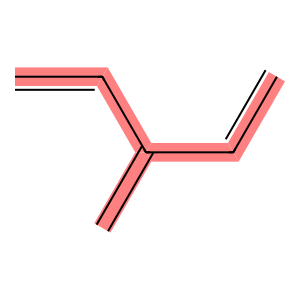

In [6]:
C6H8 = Chem.MolFromSmiles("C=CC(=C)C=C")
longest_conjugated_bond_chain, bond_matrix, bond_chain = get_longest_conjugated_bond_chain(
    mol = C6H8,
    verbose = True)
Draw.MolToImage(
    C6H8,
    highlightBonds=longest_conjugated_bond_chain,
    )

Let's label the bond indices.

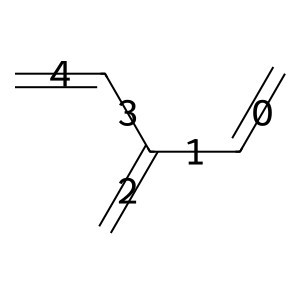

In [7]:
label_bonds(C6H8)

To understand the bond adjacency matrix, let's use [Polars' Great Tables integration](https://posit-dev.github.io/great-tables/blog/polars-styling/) to make a nicely-formatted table.

In [8]:
# Convert the bond matrix to a Polars DataFrame
df = pl.DataFrame(bond_matrix)

# Rename columns to add custom labels
df = df.rename({f"column_{str(i)}": f"Bond {i}" for i in range(bond_matrix.shape[1])})

# Add row index labels (Polars doesn't have an index column, so we'll add it as a new column)
row_indices = [f"Bond {i}" for i in range(bond_matrix.shape[0])]
index_col = "Adjacent"
df = df.insert_column(0, pl.Series(index_col, row_indices))

# Add a Total column to sum up how many bonds a given bond is connected to
total_col = "Total"
df = df.with_columns(
    pl.sum_horizontal(cs.starts_with("Bond")).alias(total_col)
)

# Use GreatTables to format the table
GT(df).tab_options(
    # Bold the column headings
    column_labels_font_weight="bold",
    # Bold the index and total columns
    ).tab_style(
        style=style.text(weight="bold"),
        locations=loc.body(columns=[index_col, total_col]),
    )

Adjacent,Bond 0,Bond 1,Bond 2,Bond 3,Bond 4,Total
Bond 0,0,1,0,0,0,1
Bond 1,1,0,1,1,0,3
Bond 2,0,1,0,1,0,2
Bond 3,0,1,1,0,1,3
Bond 4,0,0,0,1,0,1


The table demonstrates which bonds are adjacent, in the sense that the two bonds share an atom. For example, bond 1 is adjacent to bonds 0, 2, and 3. That makes sense based on the molecular diagram.

The bond chain starts with a start bond, in this case 0, and follows all its adjacent bonds to make a chain. Here, the algorithm followed the spine (longest atom chain) of the molecule to go to bonds 1, 3, and 4, then followed the other branch from bond 1 to find bond 2:

In [9]:
bond_chain

[0, 1, 3, 4, 2]

In this case, a single bond chain found all the conjugated bonds in the molecule. The algorithm has to loop over all conjugated bonds to make sure it finds the longest chain. But if a given start bond (e.g., 1) was already visited because it was in the bond chain of a previous starting bond (e.g., 0), the algorithm doesn't re-trace the same bond chain. This is a big computational savings because it avoids unnecessary graph traversals.

Additional computational savings comes from excluding the non-conjugated bonds from the adjacency matrix. While not noticeable for the example molecule because all its bonds are conjugated, this can greatly reduce the adjacency matrix, and thus the graph traversal, for molecules where some bonds are not conjugated.

### Check that longest conjugated bond chain gives expected results

Let's make sure that our algorithm gives the expected results for a variety of cyclic and acyclic molecules.

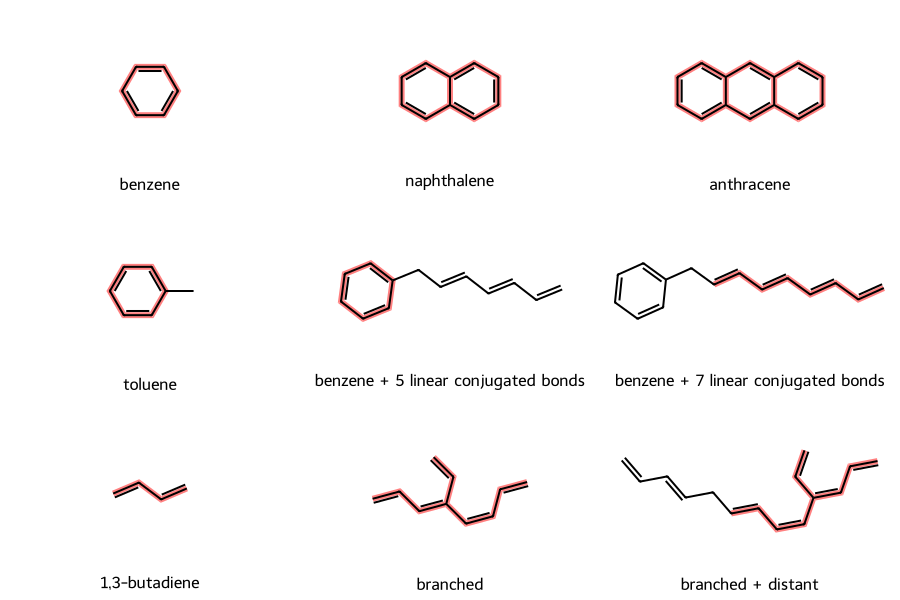

In [10]:
examples = {
    "benzene": "c1ccccc1",
    "naphthalene": "c1c2ccccc2ccc1",
    "anthracene": "c1ccc2cc3ccccc3cc2c1",
    "toluene": "c1ccccc1C",
    "benzene + 5 linear conjugated bonds": "c1ccccc1CC=CC=CC=C",
    "benzene + 7 linear conjugated bonds": "c1ccccc1CC=CC=CC=CC=C",
    "1,3-butadiene": "C=CC=C",
    "branched": "C=C\C=C/C(/C=C)=C/C=C",
    "branched + distant": "C=C\C=C\C\C=C\C=C/C(/C=C)=C/C=C",
    }
mols = [Chem.MolFromSmiles(sml) for sml in examples.values()]
conjugated_bonds = [get_longest_conjugated_bond_chain(mol) for mol in mols]
Draw.MolsToGridImage(
    mols = mols,
    legends = examples.keys(),
    highlightBondLists = conjugated_bonds,
    subImgSize = (300,200),
)

That's as expected: for example
- all the bonds are conjugated in benzene, as well as fused polycyclic molecules naphthalene and anthracene
- the bond off the ring in toluene is not conjugated
- if we put a side-chain on benzene with fewer than six conjugated bonds, the benzyl moiety remains the longest conjugated chain; but if we have seven conjugated bonds on the side chain, it becomes the longest conjugated chain
- in the "branched + distant" molecule, if we break the conjugation chain by having two C-C single bonds in a row, the chain does not include the distant, disconnected conjugated bonds

And of course we should check [beta-carotene](https://en.wikipedia.org/wiki/%CE%92-Carotene), whose red-orange color comes from its extended conjugated bond chain and is "[responsible for the orange color of carrots](https://chem.libretexts.org/Courses/Nassau_Community_College/Organic_Chemistry_I_and_II/02%3A_Structure_and_Properties_of_Organic_Molecules/2.04%3A_2.4_Conjugated_Pi_Bond_Systems)". Its molecular structure is also beautifully symmetric.

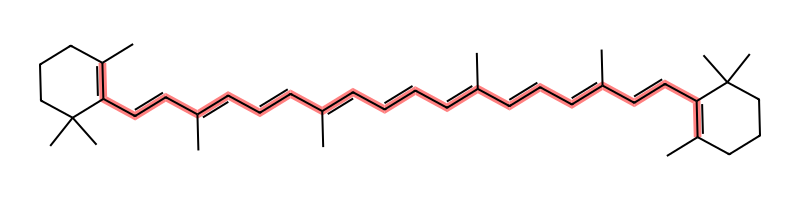

In [11]:
beta_carotene = Chem.MolFromSmiles("CC2(C)CCCC(\C)=C2\C=C\C(\C)=C\C=C\C(\C)=C\C=C\C=C(/C)\C=C\C=C(/C)\C=C\C1=C(/C)CCCC1(C)C")
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(beta_carotene)

Draw.MolToImage(
    beta_carotene,
    highlightBonds=longest_conjugated_bond_chain,
    size=(800, 200),
    )

## Prepare data

Let's read into a Polars dataframe the data from the [optical dataset CSV file](<https://figshare.com/articles/dataset/DB_for_chromophore/12045567/2?file=23637518).>).

In [12]:
df = pl.read_csv("../data/DB for chromophore_Sci_Data_rev02.csv")
df.head()

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
1,"""N#Cc1cc2ccc(O)cc2oc1=O""","""O""",355.0,410.0,2.804262,NaN,NaN,NaN,NaN,NaN,NaN,187.1537,"""DOI: 10.1021/acs.jpcb.5b09905"""
2,"""N#Cc1cc2ccc([O-])cc2oc1=O""","""O""",408.0,450.0,3.961965,NaN,NaN,NaN,NaN,NaN,43.0,186.14576,"""DOI: 10.1021/acs.jpcb.5b09905"""
3,"""CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(…","""ClC(Cl)Cl""",526.0,535.0,3.602954,NaN,NaN,NaN,NaN,NaN,NaN,1061.54348,"""https://doi.org/10.1002/smll.2…"
4,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CC#N""",514.0,553.72,3.81,NaN,NaN,NaN,NaN,NaN,67.4,350.42028,"""https://doi.org/10.1016/j.snb.…"
5,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CS(C)=O""",524.0,555.0,4.7,NaN,NaN,NaN,NaN,58.0,50.0,350.42028,"""https://doi.org/10.1016/j.snb.…"


TODO Explain wavelength to energy conversion

The dataset gives absorption and emission maxima as wavelengths. That makes sense because spectroscopists wavelength describes the color of the light used in the laboratory. But to compare, for example, the absorption and emission maximum for a molecule, it's better to use energy units because those give the difference between different molecular states. So let's convert wavelengths to energies in electron volts, eV.

In [13]:
@latexify.function
def E(
    h: float,
    c: float,
    λ: float,
    ) -> float:
    """Calculate the binomial coefficient: how many ways there are to choose k items from n items
    :param h: Planck's constant
    :param c: speed of light
    :param λ: wavelength
    :returns: energy
    """
    return h * c / λ

E

Let's plug in the values from [KMLabs Inc](https://www.kmlabs.com/en/wavelength-to-photon-energy-calculator) and use factor-label dimensional analysis:

In [14]:
eqn = r'$\frac{6.6261 \times 10^{-34} \, \text{J} \cdot \text{s} \cdot 2.9979 \times 10^8 \, \text{m/s}}{\lambda \times 10^{-9} \, \text{m}} \cdot \frac{1 \, \text{eV}}{1.602176634 \times 10^{-19} \, \text{J}} = \frac{1239.8 \, \text{eV}}{\lambda}$'
display(Math(eqn))

<IPython.core.display.Math object>

Doing that in Python to come up with a value:

In [15]:
h = 6.6261e-34 # J*s
c = 2.9979e8 # m/s
nm = 1e-9 # m
eV = 1.602176634e-19 # J
eV_nm = h * c / (nm * eV)
eV_nm

1239.83740421969

Now we can convert absorption and emission maxima to energy units of eV, then calculate their difference as the Stokes shift. The Stokes shift reflects how much the molecule relaxes from its initial excited state (the [Franck–Condon state](https://en.wikipedia.org/wiki/Franck%E2%80%93Condon_principle)) to the relaxed excited state that it emits light from.

In [16]:
for column in ["longest_bond_indices", "longest_bond_length", "Absorption max (eV)", "Emission max (eV)", "Stokes shift (eV)"]:
   try:
      df.drop(column)
   except:
      pass

In [17]:
df = df.with_columns(
    [
        (eV_nm / pl.col("Absorption max (nm)")).alias("Absorption max (eV)"),
        (eV_nm / pl.col("Emission max (nm)")).alias("Emission max (eV)"),
        ]
).with_columns(
        (pl.col("Absorption max (eV)") - pl.col("Emission max (eV)")).alias("Stokes shift (eV)"),
)

## Finding the longest conjugated chain for each molecule

Now we come to the computationally-intensive operation: Finding the the longest conjugated chain for each molecule. We define a function that will return the indices and length of the longest conjugated bond chain.

In [18]:
def conjugated_chains(sml):
    return_dict = dict()
    mol = Chem.MolFromSmiles(sml)
    longest_bond_indices = get_longest_conjugated_bond_chain(mol)
    length = len(longest_bond_indices)
    return_dict["longest_bond_indices"] = longest_bond_indices
    return_dict["longest_bond_length"]=length
    return return_dict

Now we use Polars' map_elements to calculate the longest bond chain for each molecule. Because `conjugated_chains` returns a dictionary, Polars treats it as a `struct`, which we can then `unnest` to create a column for each dictionary key-value pair. This operation takes about 30 seconds on my laptop.
We then sort to put the longest bond chain lengths first.

In [19]:
# This may take 30 seconds
df = df.with_columns(
   conjugated = pl.col('Chromophore').map_elements(lambda sml: conjugated_chains(sml), return_dtype=pl.Struct)
).unnest('conjugated').sort(pl.col("longest_bond_length"), descending=True).shrink_to_fit()

Checking the results, we find that the longest conjugated bond chain length in the optical dataset is 158 bonds!

In [20]:
df.head()

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,Absorption max (eV),Emission max (eV),Stokes shift (eV),longest_bond_indices,longest_bond_length
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,list[i64],i64
15095,"""c1ccc(C(=C(c2ccccc2)c2ccc(-c3c…","""Cc1ccccc1""",530.0,637.0,NaN,0.252,NaN,NaN,NaN,NaN,NaN,1762.28448,"""https://doi.org/10.1016/j.dyep…",2.339316,1.94637,0.392946,"[0, 1, … 157]",158
15096,"""c1ccc(C(=C(c2ccccc2)c2ccc(-c3c…","""ClCCl""",520.0,647.0,6.7,0.093,NaN,NaN,NaN,NaN,NaN,1762.28448,"""https://doi.org/10.1016/j.dyep…",2.384303,1.916287,0.468016,"[0, 1, … 157]",158
5658,"""c1ccc(-n2c(-c3ccc(N(c4ccc(-c5c…","""ClCCl""",376.0,432.0,1.68,0.206,NaN,NaN,NaN,60.4,62.7,1657.99344,"""https://doi.org/10.1016/j.orge…",3.29744,2.869994,0.427446,"[0, 1, … 154]",155
5659,"""Cc1ccc(-n2c(-c3ccc(N(c4ccc(-c5…","""ClCCl""",376.0,435.0,1.68,0.282,NaN,NaN,NaN,61.2,62.1,1714.10096,"""https://doi.org/10.1016/j.orge…",3.29744,2.850201,0.447239,"[1, 2, … 158]",155
5660,"""CC(C)(C)c1ccc(-n2c(-c3ccc(N(c4…","""ClCCl""",377.0,430.0,3.8,0.451,NaN,NaN,NaN,69.9,57.5,1882.42352,"""https://doi.org/10.1016/j.orge…",3.288693,2.883343,0.405351,"[4, 5, … 170]",155


## Checking for a correlation of absorption wavelength against longest conjugated bond chain length

Let's use [Polars' `plot`](https://docs.pola.rs/api/python/stable/reference/dataframe/plot.html) capability to plot absorption max against longest bond length to check for any trends. There are two things we need to do first:
- Enable [VegaFusion](https://vegafusion.io/) because there are so many data points
- Drop the column longest_bond_indices because large lists of integers are not supported (we're not plotting them anyway)
Other than that, it's very simple to make a quick plot.

In [21]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [22]:
df.drop("longest_bond_indices").plot.scatter(x="longest_bond_length", y="Absorption max (nm)")

alt.Chart(...)

While absorption max might generally, loosely correlate with longest bond length, it's hard to recognize much of a trend, presumably because of the varied molecular structures.

### Seeking a series of related molecules

Let's remove other variables by finding a series of molecules with a similar structure, but where the longest bond length increases. Given our dataset, let's start with molecules with a large number of connected conjugated bonds, then find a simple, linear molecule with a repeat unit that we can look for analogues with fewer repeat units. We'll plot the top 50 molecules, which is the RDKit's default maximum.

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


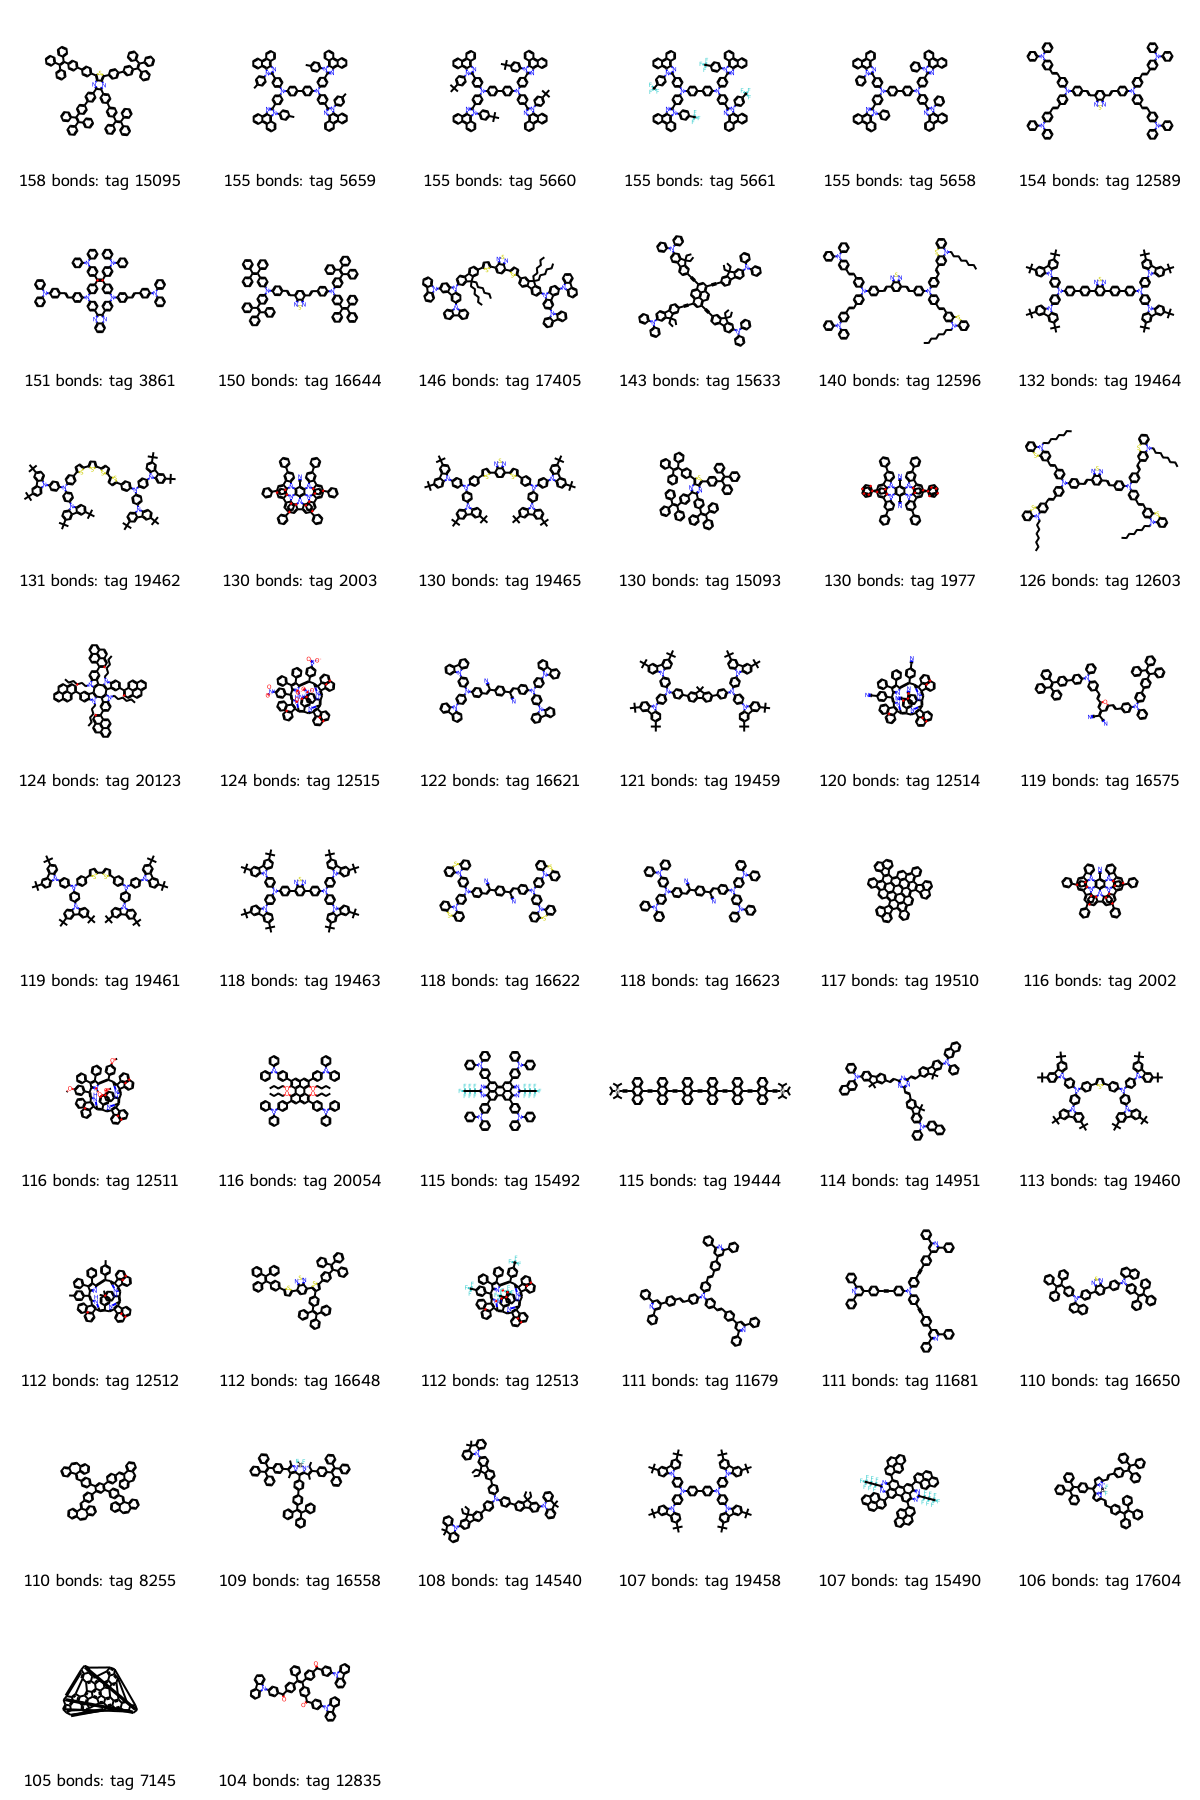

In [23]:
df_unique_chromophore = df.unique(subset="Chromophore").sort("longest_bond_length", descending=True)
matching = df_unique_chromophore["Chromophore"].to_list()
tags = df_unique_chromophore["Tag"].to_list()
longest_bond_lengths = df_unique_chromophore["longest_bond_length"].to_list()
legends = [f"{longest_bond_length} bonds: tag {tag}" for (tag, longest_bond_length) in zip(tags, longest_bond_lengths)]
mols = [Chem.MolFromSmiles(match) for match in matching]
Draw.MolsToGridImage(
    mols = mols,
    legends = legends,
    molsPerRow = 6,
    )

While there are a lot of interesting-looking molecules, tag 19444 has a simple linear structure with a clear repeat unit that includes an anthracene moiety. This molecule has six of those repeat units, so we'll refer to it as the `n = 6` molecule. Let's show the molecule with its conjugated chain highlighted.

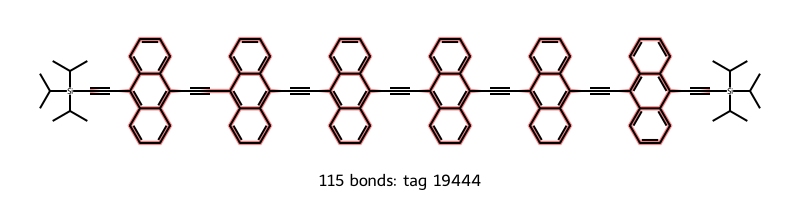

In [24]:
df_19444 = df_unique_chromophore.filter(Tag=19444)
sml_19444 = df_19444[0]["Chromophore"].item()
mol_19444 = Chem.MolFromSmiles(sml_19444)
tag = df_19444[0]["Tag"].item()
longest_bond_length = df_19444[0]["longest_bond_length"].item()
legend = f"{longest_bond_length} bonds: tag {tag}"
conjugated_bonds_19444 = df_19444[0]["longest_bond_indices"].item().to_list()
Draw.MolToImage(
    mol = mol_19444,
    size = (800,200),
    legend = legend,
    highlightBonds = conjugated_bonds_19444,
)

By the way, the RDKit seems to have trouble highlighting all the bonds in the image; there is in fact a contiguous chain from the first triple bond to the last.

Now let's show the repeat unit in the same orientation as the molecule, which requires rotating the atoms of the repeat unit by 90 degrees.

We'll rotate serval molecules in this post by 90 degrees, so let's define a function to do that.

In [25]:
def rotate_90(smiles):
    """
    Rotates a molecule by 90 degrees based on its SMILES string and visualizes it.
    
    Args:
        smiles (str): SMILES string of the molecule to rotate.
    
    Returns:
        RDKit Molecule: The rotated molecule.
    """
    
    # Load the molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate 2D coordinates if not already present
    AllChem.Compute2DCoords(mol)
    
    # Define the rotation matrix for 90 degrees (π/2 radians)
    theta = np.pi / 2  # 90 degrees in radians
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])
    
    # Get the conformation of the molecule (the 2D coordinates)
    conf = mol.GetConformer()
    
    # Apply the rotation to each atom
    for i in range(mol.GetNumAtoms()):
        # Get the current x, y, z coordinates (z will stay 0.0 for 2D)
        pos = conf.GetAtomPosition(i)
        x, y = pos.x, pos.y  # Extract x, y coordinates
        
        # Apply the 90-degree rotation
        new_x, new_y = np.dot(rotation_matrix, [x, y])
        
        # Set the new coordinates, keeping z=0.0
        conf.SetAtomPosition(i, (new_x, new_y, 0.0))

    # Return the rotated molecule
    return mol

Now we can show the repeat unit in the same orientation that it appears in the `n = 6` molecule. The RDKit tends to recalculate molecular coordinates, so to be safe we assign the output image of `Draw.MolToImage` to a variable, then `display` that image.

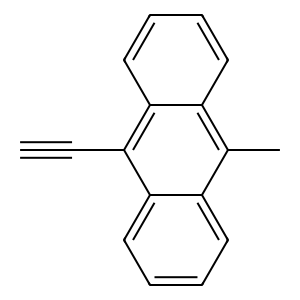

In [26]:
repeat_unit = "CC1=C2C=CC=CC2=C(C#C)C2=CC=CC=C12"
repeat_unit_mol = Chem.MolFromSmiles(repeat_unit)

repeat_unit_mol = rotate_90(repeat_unit)
img = Draw.MolToImage(
    repeat_unit_mol,
    )
display(img)

Let's check the dataframe for molecules with the same overall structure and fewer repeat units.

#### Filter to molecules in the series

Let's define a function to check how many of a given substructure are in a molecule.

In [27]:
def mol_props(
        sml, 
        smls_to_match:Iterable[str]=None,
        ):
    """
    Convert SMILES to an RDKit molecule, then calculate various properties of it
    :returns: dictionary of molecular properties
    :param sml: SMILES to convert to a molecule
    :param smls_to_match: SMILES to convert to a molecule
    """
    mol = Chem.MolFromSmiles(sml)
    return_dict = dict()
    for name, sml_to_match in smls_to_match.items():
        mol_to_match = Chem.MolFromSmiles(sml_to_match)
        matches = mol.GetSubstructMatches(mol_to_match)
        return_dict[f"{name}_match_count"] = len(matches)
    return return_dict

We'll start filtering by checking for the repeat unit. To prevent double-counting of the number of repeat units, we use a substructure one atom longer than we showed above.

In [28]:
smls_to_match = {
    # Repeat unit containing an anthracene moiety
   "repeat_unit": "C#CC1=C2C=CC=CC2=C(C#C)C2=CC=CC=C12",
}

Let's highlight one instance of the repeat unit, and of the terminal group, in the `n = 6` molecule. Because we'll search by atoms (the substructure), and then want to highlight the bonds as well, we'll define a function to get the bond indices connecting an iterable of atoms.

In [29]:
def get_bond_indices_connecting_atoms(mol, atom_indices):
    """
    Given an RDKit molecule and a list of atom indices, return the bond indices
    that connect the atoms in the list.
    
    :param mol: RDKit molecule object
    :param atom_indices: List of atom indices to check for connectivity
    :return: List of bond indices that connect the atoms in atom_indices
    """
    bond_indices = []
    atom_set = set(atom_indices)  # Using a set for faster lookup

    # Iterate through all bonds in the molecule
    for bond in mol.GetBonds():
        begin_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()

        # Check if both atoms of the bond are in the provided list of atom indices
        if begin_atom in atom_set and end_atom in atom_set:
            bond_indices.append(bond.GetIdx())

    return bond_indices

We filter the dataframe down to the `n = 6` molecule based on its tag number, then operate on that row.

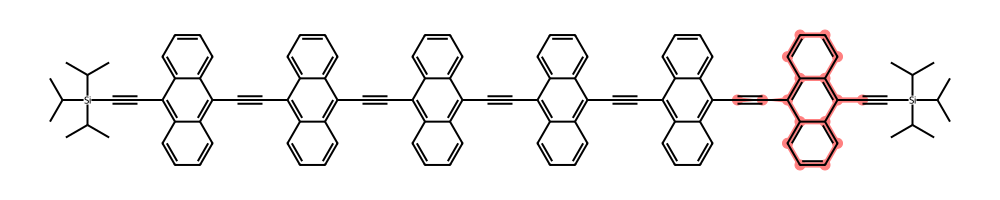

In [31]:
df_19444 = df_unique_chromophore.filter(Tag=19444)
sml_19444 = df_19444[0]["Chromophore"].item()
mol_19444 = Chem.MolFromSmiles(sml_19444)
match_repeat_unit = mol_19444.GetSubstructMatches(repeat_unit_mol)[0]
bond_indices_repeat_unit = get_bond_indices_connecting_atoms(mol_19444, match_repeat_unit)
# terminal_mol = Chem.MolFromSmiles(smls_to_match["terminal"])
# match_terminal = mol_19444.GetSubstructMatches(terminal_mol)[-1]
# bond_indices_terminal = get_bond_indices_connecting_atoms(mol_19444, match_terminal)
Draw.MolToImage(
    mol_19444,
    highlightAtoms = match_repeat_unit, #+ match_terminal,
    highlightBonds = bond_indices_repeat_unit, # + bond_indices_terminal,
    size = (1000,200),
)

To avoid duplicate-column errors when the code is run more than once, we'll drop any existing match count columns. Then we'll count the occurrences of each substructure in each molecule.

In [40]:
def add_match_counts(
        df,
        smls_to_match,
):
   df = df.drop(cs.ends_with("_match_count"))
   df = df.with_columns(
      molecular_props = pl.col('Chromophore').map_elements(lambda sml: mol_props(sml, smls_to_match), return_dtype=pl.Struct)
   ).unnest('molecular_props').sort("longest_bond_length", descending=True).shrink_to_fit()
   return df

In [41]:
df = add_match_counts(
    df = df,
    smls_to_match = smls_to_match,
)

Let's filter down to molecules that contain the repeat unit.

In [38]:
df.filter(
    (pl.col("repeat_unit_match_count") > 0)
        ).sort(pl.col("repeat_unit_match_count"))

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,Absorption max (eV),Emission max (eV),Stokes shift (eV),longest_bond_indices,longest_bond_length,repeat_unit_match_count,terminal_match_count,too_many_rings_match_count,too_many_rings_N_match_count
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,list[i64],i64,i64,i64,i64,i64
18923,"""CCCCCCCCn1c(=O)c2cc3c(C#Cc4ccc…","""ClC(Cl)Cl""",582.0,641.0,3.4,0.53,4.518514,NaN,NaN,NaN,NaN,1075.36204,"""DOI: 10.1021/acs.joc.6b00364""",2.130305,1.934224,0.196081,"[8, 9, … 91]",76,1,0,0,0
19570,"""O=c1c2ccccc2c2nc3cc4c(C#C[Si](…","""ClCCl""",731.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1239.80484,"""DOI: 10.1021/acs.joc.9b02756""",1.696084,NaN,NaN,"[0, 1, … 107]",64,1,2,0,2
19577,"""O=c1c2ccccc2c2nc3cc4c(C#C[Si](…","""O=c1c2ccccc2c2nc3cc4c(C#C[Si](…",743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1239.80484,"""DOI: 10.1021/acs.joc.9b02756""",1.668691,NaN,NaN,"[0, 1, … 107]",64,1,2,0,2
19367,"""COc1ccc(C#Cc2c3cc4ccccc4cc3c(C…","""ClCCl""",666.0,706.0,4.6,0.03,4.436163,NaN,NaN,NaN,62.3,538.64444,"""DOI: 10.1021/jo501696d""",1.861618,1.756144,0.105474,"[1, 2, … 47]",46,1,0,2,0
19516,"""COc1c2ccccc2c(OC)c2c(C#Cc3cccc…","""ClCCl""",704.0,718.0,NaN,0.11,4.130334,NaN,NaN,NaN,NaN,538.64444,"""DOI: 10.1021/jo0710331""",1.761133,1.726793,0.03434,"[1, 2, … 47]",46,1,0,2,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
19440,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",523.0,541.0,NaN,0.02,4.694605,NaN,NaN,NaN,NaN,963.6346,"""DOI: 10.1021/acs.joc.8b00311""",2.370626,2.291751,0.078875,"[4, 5, … 74]",39,2,2,0,0
19441,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",570.0,589.0,NaN,0.022,4.781037,NaN,NaN,NaN,NaN,1276.08916,"""DOI: 10.1021/acs.joc.8b00311""",2.175153,2.104987,0.070166,"[4, 5, … 101]",58,3,2,0,0
19442,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",582.0,609.0,NaN,0.02,4.975432,NaN,NaN,NaN,NaN,1139.68356,"""DOI: 10.1021/acs.joc.8b00311""",2.130305,2.035858,0.094447,"[4, 5, … 96]",77,4,2,0,0


That's too many molecules--we expect as many as six, for `n = 1 - 6`. Let's examine the molecular structures to understand why.

Because we'll plot several instances of molecular grids from subsets of the dataframe, we define a function to plot the molecules and legends based on the columns in the dataframe.

In [42]:
def df_to_grid_image(
        df,
        subImgSize = (200, 200),
        molsPerRow = 3,
        ):
    matching = df["Chromophore"].to_list()
    mols = [Chem.MolFromSmiles(match) for match in matching]
    num_match = df["repeat_unit_match_count"].to_list()
    absorbance_nm = df["Absorption max (nm)"].to_list()
    legends = []
    for index in range(len(num_match)):
        legend = f"{num_match[index]} unit(s)"
        abs_nm = absorbance_nm[index]
        if not math.isnan(abs_nm):
            legend += f" {abs_nm}nm"
        legends.append(legend)
    conjugated_bonds = [get_longest_conjugated_bond_chain(mol) for mol in mols]
    print(f"{len(mols)} molecules")
    dwg = Draw.MolsToGridImage(
        mols = mols,
        legends = legends,
        maxMols = 10,
        molsPerRow = molsPerRow,
        highlightBondLists = conjugated_bonds,
        subImgSize = subImgSize,
    )
    return dwg

51 molecules


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


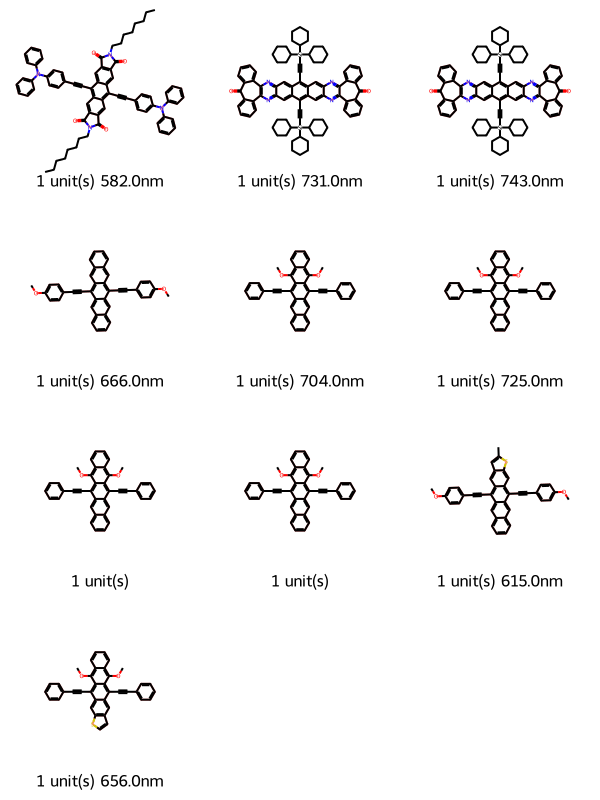

In [44]:
df_to_grid_image(df.filter(
    (pl.col("repeat_unit_match_count") > 0)
        ).sort(pl.col("repeat_unit_match_count")))

None of the first 10 molecules have the two terminal triisopropylsyl groups. Let's specify that we want two such terminal groups by adding the terminal group to the list of SMILES to match, then filtering to molecules with two of those terminal groups.

In [47]:
smls_to_match = smls_to_match | {
    # Terminal triisopropylsyl group
    "terminal": "CC(C)[SiH](C(C)C)C(C)C"
}

Here are the substructures we're searching for now:

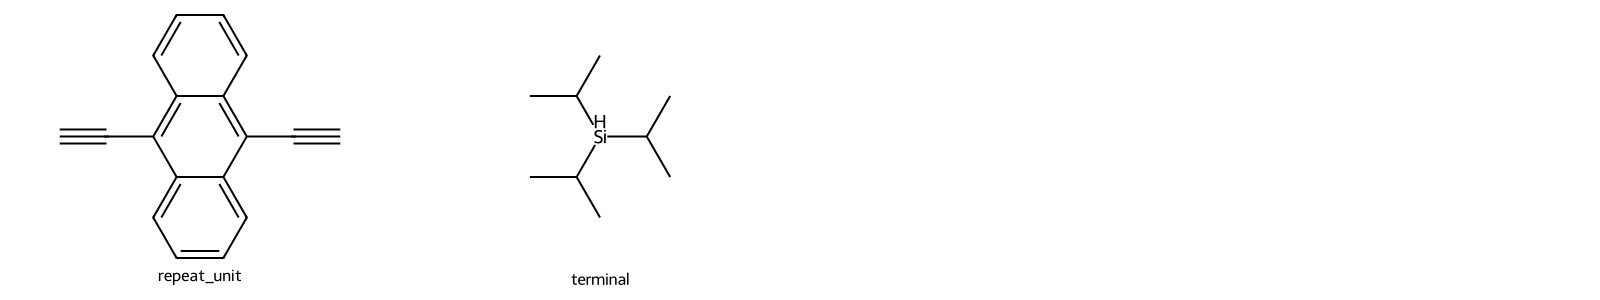

In [48]:
mols_to_match = []
for sml in smls_to_match.values():
    mol = rotate_90(sml)
    mols_to_match.append(mol)
img = Draw.MolsToGridImage(
    mols = mols_to_match,
    legends = smls_to_match.keys(),
    molsPerRow = 4,
    subImgSize = (400, 300)
)
display(img)

In [45]:
df = add_match_counts(
    df = df,
    smls_to_match = smls_to_match,
)

19 molecules


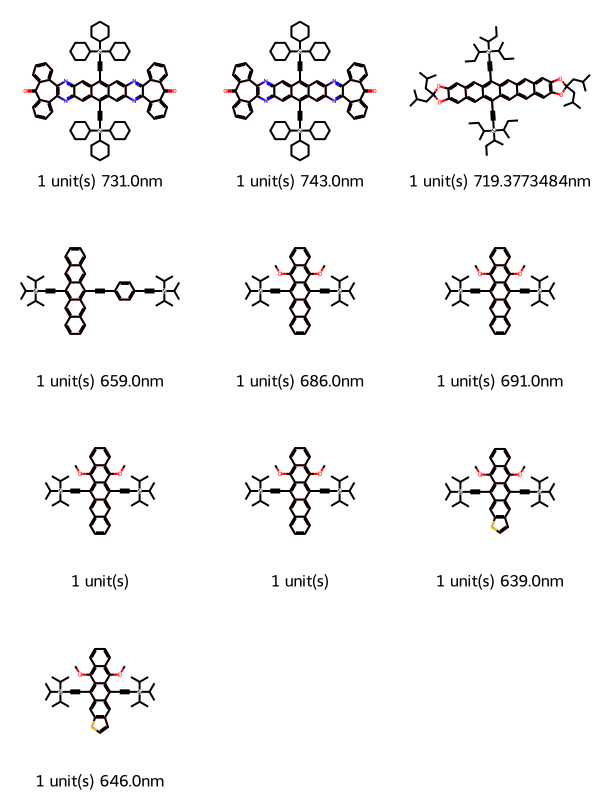

In [40]:
df_to_grid_image(df.filter(
    (pl.col("repeat_unit_match_count") > 0) & (
        pl.col("terminal_match_count") == 2)
            ).sort(pl.col("repeat_unit_match_count")))

That helps, but we're getting a lot of fused-ring systems with more than three rings. Let's exclude those by adding SMILES to match that contain four fused rings, where the fourth ring is either all carbons, or contains two nitrogens.

In [50]:
smls_to_match = smls_to_match | {
   # Four benzene rings
   "too_many_rings": "C#CC1=C2C=C3C=CC=CC3=CC2=C(C#C)C2=CC=CC=C12",
   # Four rings: Three benzene and one dinitrogen ring
   "too_many_rings_N": "C#CC1=C2C=C3N=CC=NC3=CC2=C(C#C)C2=CC=CC=C12",
}

Here are the substructures we're searching for now, where the first row are substructures we want to include, while the second row is substructures we want to exclude.

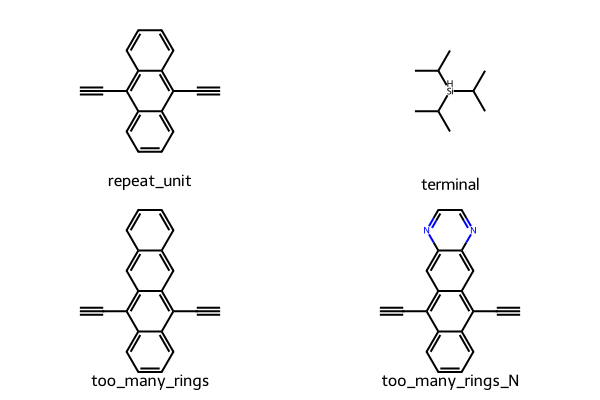

In [54]:
mols_to_match = []
for sml in smls_to_match.values():
    mol = rotate_90(sml)
    mols_to_match.append(mol)
img = Draw.MolsToGridImage(
    mols = mols_to_match,
    legends = smls_to_match.keys(),
    molsPerRow = 2,
    subImgSize = (300, 200)
)
display(img)

We'll exclude the four-fused-ring substructures by setting their count to zero.

6 molecules


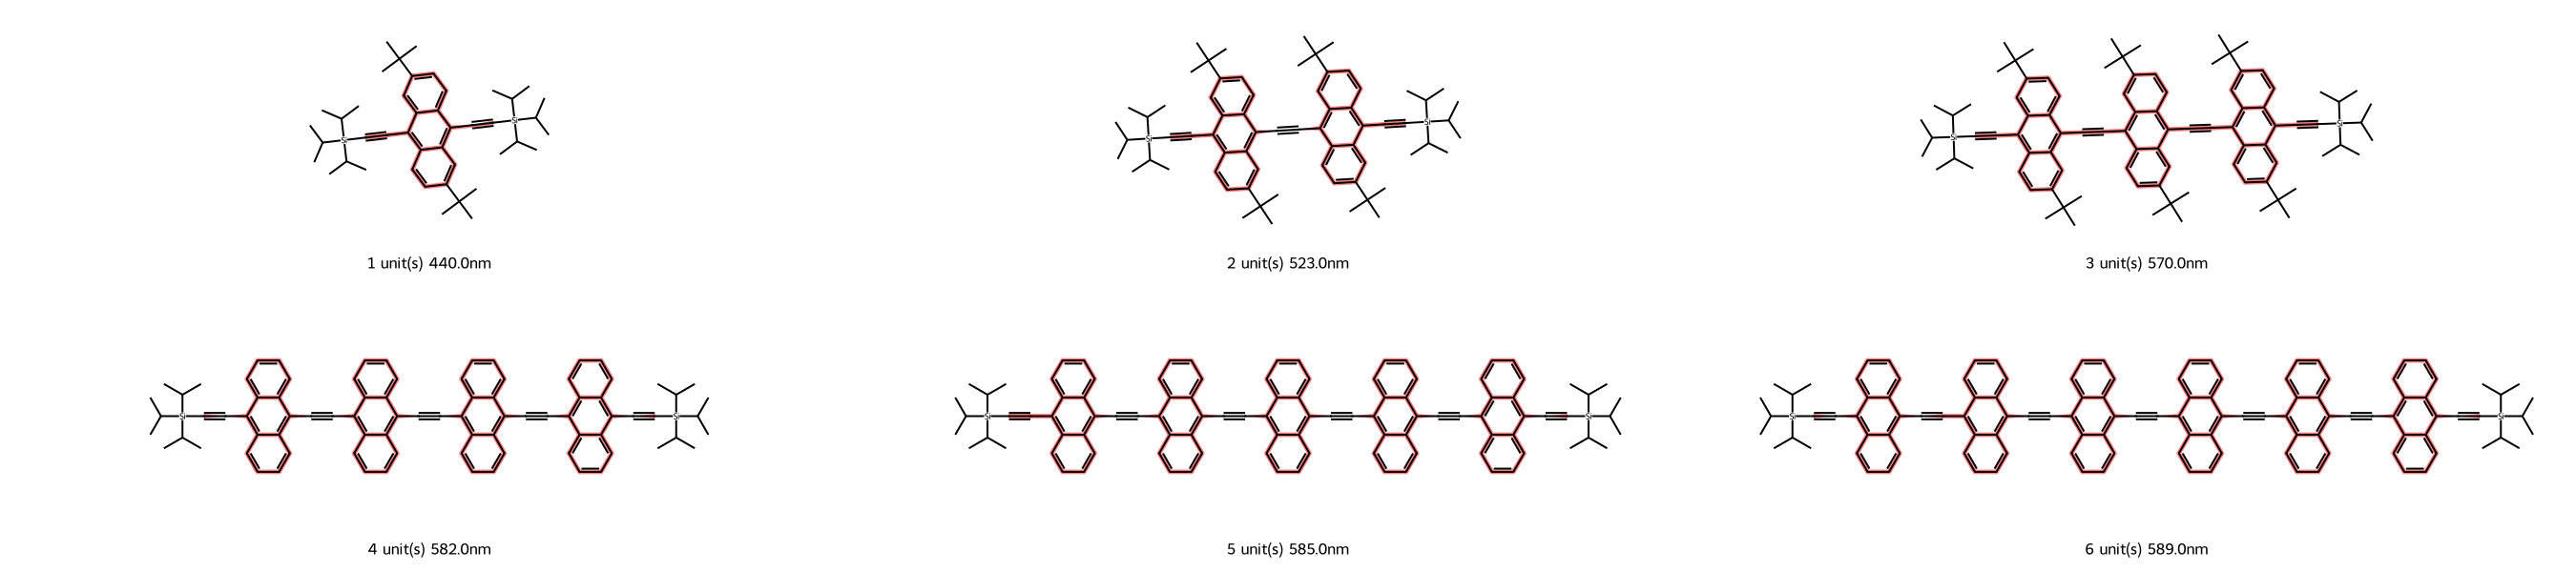

In [41]:
df_matches = df.filter(
    (pl.col("repeat_unit_match_count") > 0) & (
        pl.col("terminal_match_count") == 2) & (
            pl.col("too_many_rings_match_count") == 0) & (
                pl.col("too_many_rings_N_match_count") == 0
            )
        ).sort(pl.col("repeat_unit_match_count"))
df_to_grid_image(
    df_matches,
    subImgSize = (900, 300),
    molsPerRow = 3,
    )

In [42]:
df_matches

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,Absorption max (eV),Emission max (eV),Stokes shift (eV),longest_bond_indices,longest_bond_length,repeat_unit_match_count,terminal_match_count,too_many_rings_match_count,too_many_rings_N_match_count
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,list[i64],i64,i64,i64,i64,i64
19439,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",440.0,461.0,NaN,0.92,4.4133,NaN,NaN,NaN,NaN,651.18004,"""DOI: 10.1021/acs.joc.8b00311""",2.817812,2.689452,0.12836,"[4, 5, … 47]",20,1,2,0,0
19440,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",523.0,541.0,NaN,0.02,4.694605,NaN,NaN,NaN,NaN,963.6346,"""DOI: 10.1021/acs.joc.8b00311""",2.370626,2.291751,0.078875,"[4, 5, … 74]",39,2,2,0,0
19441,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",570.0,589.0,NaN,0.022,4.781037,NaN,NaN,NaN,NaN,1276.08916,"""DOI: 10.1021/acs.joc.8b00311""",2.175153,2.104987,0.070166,"[4, 5, … 101]",58,3,2,0,0
19442,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",582.0,609.0,NaN,0.02,4.975432,NaN,NaN,NaN,NaN,1139.68356,"""DOI: 10.1021/acs.joc.8b00311""",2.130305,2.035858,0.094447,"[4, 5, … 96]",77,4,2,0,0
19443,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",585.0,623.0,NaN,0.018,5.130334,NaN,NaN,NaN,NaN,1339.92308,"""DOI: 10.1021/acs.joc.8b00311""",2.11938,1.990108,0.129272,"[4, 5, … 115]",96,5,2,0,0
19444,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",589.0,629.0,NaN,NaN,5.178977,NaN,NaN,NaN,NaN,1540.1626,"""DOI: 10.1021/acs.joc.8b00311""",2.104987,1.971125,0.133862,"[4, 5, … 134]",115,6,2,0,0


Great! We have just the molecules we want, and the dataset contains all six of them: `n = 1 - 6`. In all cases, the solvent is toluene:

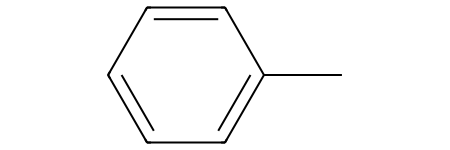

In [57]:
Chem.MolFromSmiles(df[0]["Solvent"].item())

The molecules have the same repeat unit except that `n = 1 - 3` have a tert-butyl group on each off-axis phenyl ring. To a first approximation, I wouldn't expect those to affect the optical properties significantly because they're not conjugated, so we'll treat the molecules `n = 1 - 6` as a series.

By the way, those four substructure criteria are sufficient to get just the set of molecules we want from this dataset. If we had a larger dataset, we might have to add more criteria to exclude closer matches.

## Plot results

Now that we have a fairly consistent series of molecules, let's plot their optical properties to check for trends. We'll use the [altair](https://altair-viz.github.io/) library that provides Polars' plotting capability. 

We'll start by setting our color scheme for the absorption, emission, and Stokes shift series.

In [55]:
absorption_color = 'blue'
emission_color = 'red'
stokes_color = 'orange'

Next we calculate plot ranges based on the data.

In [44]:
# Calculate the minimum and maximum y-value in nm across the absorption and emission series
min_y_value = min(df_matches['Absorption max (nm)'].min(), df_matches['Emission max (nm)'].min())
y_min = min_y_value * 0.95  # Adjust to 95% of the minimum value for a slight buffer
max_y_value = max(df_matches['Absorption max (nm)'].max(), df_matches['Emission max (nm)'].max())
y_max = max_y_value * 1.05  # Adjust to 105% of the maximum value for a slight buffer

# Calculate the minimum and maximum y-value in eV across the absorption and emission series
min_y_value_eV = min(df_matches['Absorption max (eV)'].min(), df_matches['Emission max (eV)'].min())
y_min_eV = min_y_value_eV * 0.95  # Adjust to 95% of the minimum value for a slight buffer
max_y_value_eV = max(df_matches['Absorption max (eV)'].max(), df_matches['Emission max (eV)'].max())
y_max_eV = max_y_value_eV * 1.05  # Adjust to 105% of the maximum value for a slight buffer

# Calculate the maximum y-value in eV for the Stokes shifts
stokes_y_max = df_matches['Stokes shift (eV)'].max() * 1.1

# Calculate the maximum x-value for all series, namely the maximum repeat unit count plus a buffer
max_x_value = df_matches['repeat_unit_match_count'].max() + 0.5

Now we can plot the data. Let's start with the wavelength units in the source dataset, namely nanometers (nm). We'll make a scatter plot for the absorption series, then one for the emission series, and layer them on top of each other. For the legend, we'll make a separate "plot" and concatenate it horizontally with the main plot.

In [45]:
# First scatter plot for "Absorption max (nm)"
scatter_absorption = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y='Absorption max (nm)',
    color=alt.value(absorption_color),
    tooltip=['repeat_unit_match_count', 'Absorption max (nm)']
).properties(
    title="Absorption max"
)

# Second scatter plot for "Emission max (nm)"
scatter_emission = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y='Emission max (nm)',
    color=alt.value(emission_color),
    tooltip=['repeat_unit_match_count', 'Emission max (nm)']
).properties(
    title="Emission max"
)

# Create a manual legend using Polars
legend_data = pl.DataFrame({
    'Type': ['Absorption max (nm)', 'Emission max (nm)'],
    'Color': [absorption_color, emission_color]
})
legend = alt.Chart(legend_data).mark_point(size=100).encode(
    y=alt.Y('Type:N', axis=alt.Axis(orient='right')),
    color=alt.Color('Color:N', scale=None)
)

# Combine the scatter plot and legend
scatter_combined = alt.layer(
    scatter_absorption, scatter_emission
).properties(
    title='Absorption and Emission Max Scatter Plot'
).encode(
    y=alt.Y('Absorption max (nm)', scale=alt.Scale(domain=[y_min, y_max]), title="Absorption and emission max (nm)"),
    x=alt.X('repeat_unit_match_count', scale=alt.Scale(domain=[0.5, max_x_value]), title="# repeat units")
).interactive()

# Display the chart with the legend
layered_chart = alt.hconcat(scatter_combined, legend)

layered_chart.show()

alt.HConcatChart(...)

As we discussed earlier, it's better to plot in terms of energy. Let's do that and add the Stokes shift on the same x-axis, but below the main plot.

In [47]:
# First scatter plot for "Absorption max (eV)" and "Emission max (eV)" (upper part of the y-axis)
scatter_absorption = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y=alt.Y('Absorption max (eV)', scale=alt.Scale(domain=[y_min_eV, y_max_eV])),
    color=alt.value(absorption_color),
    tooltip=['repeat_unit_match_count', 'Absorption max (eV)']
)

scatter_emission = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y=alt.Y('Emission max (eV)', scale=alt.Scale(domain=[y_min_eV, y_max_eV])),  # Same y-axis range as absorption
    color=alt.value(emission_color),
    tooltip=['repeat_unit_match_count', 'Emission max (eV)']
)

# Second scatter plot for "Stokes shift (eV)" (lower part of the y-axis)
scatter_stokes = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y=alt.Y('Stokes shift (eV)', scale=alt.Scale(domain=[0, stokes_y_max])),  # Stokes shift on a different y-axis range
    color=alt.value(stokes_color),
    tooltip=['repeat_unit_match_count', 'Stokes shift (eV)']
)

# Manual legend with explicit sort order
legend_data = pl.DataFrame({
    'Type': ['Absorption max (eV)', 'Emission max (eV)', 'Stokes shift (eV)'],
    'Color': [absorption_color, emission_color, stokes_color]
})

legend = alt.Chart(legend_data).mark_point(size=100).encode(
    y=alt.Y('Type:N', sort=['Absorption max (eV)', 'Emission max (eV)', 'Stokes shift (eV)'],  # Explicit sort order
            axis=alt.Axis(orient='right', title=None)),
    color=alt.Color('Color:N', scale=None)
).properties(
    width=50
)

# Layer the two scatter plots, but apply y-axis breaks by separating ranges
upper_chart = alt.layer(
    scatter_absorption, scatter_emission
).encode(
    y=alt.Y(
        'Absorption max (eV)', 
        scale=alt.Scale(domain=[y_min_eV, y_max_eV]), 
        title="Absorption or emission max (eV)"
    ),
    x=alt.X(
        'repeat_unit_match_count', 
        scale=alt.Scale(domain=[0.5, max_x_value]), 
        title=None,
        axis=alt.Axis(labels=False, tickSize=0),
    )
)

lower_chart = scatter_stokes.encode(
    y=alt.Y(
        'Stokes shift (eV)', 
        scale=alt.Scale(domain=[0, stokes_y_max]), 
        title="Stokes shift (eV)"
    ),
    x=alt.X(
        'repeat_unit_match_count', 
        scale=alt.Scale(domain=[0.5, max_x_value]), 
        title="# Repeat Units"
    )
)

# Combine the two charts vertically with some padding to simulate a break
combined_chart = alt.vconcat(
    upper_chart.properties(height=300),
    lower_chart.properties(height=100),
    spacing=10  # Add space between charts to simulate axis break
).resolve_scale(
    x='shared'
)

# Display the combined chart with the legend
layered_chart = alt.hconcat(combined_chart, legend)

layered_chart.show()

alt.HConcatChart(...)

The Stokes shift is relatively constant, ranging between 0.7 and 0.14 eV, despite the absortion maximum decreasing by ~0.7 eV from n = 1 to n = 6. The Stokes shift does show a trend, decreasing from n = 1 until n = 3, then increasing up to n = 6, which may be due to conflicting factors.

The fluorescence quantum yield is 0.92 for n = 1, and about 0.02 for n = 2-5 (a value is not provided for n=6). This could be due to several factors, for example
- the longer the molecule, the less structurally rigid it is due to e.g. rotation around C-C single bonds, which allows for non-radiative decay
- the energy gap law states that the non-radiative decay rate exponentially increases as the energy gap decreases:

In [48]:
energy_gap_law = r'k_{\mathrm{nr}} \propto \exp\left(-\frac{E_{\mathrm{gap}}}{\lambda}\right)'
display(Math(energy_gap_law))

<IPython.core.display.Math object>

In [49]:
df_matches = df_matches.with_columns(
    ((pl.col("Absorption max (eV)") * -1 / 0.06199).exp()).alias("k_nr")
)

In [50]:
df_matches.plot.scatter(x="repeat_unit_match_count", y="k_nr")

alt.Chart(...)